In [1]:
from scipy.interpolate import CubicSpline
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import pandas as pd
import seaborn as sns;
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
from tsmoothie.smoother import *
from tsmoothie.bootstrap import BootstrappingWrapper
from tsmoothie.utils_func import create_windows, sim_seasonal_data, sim_randomwalk

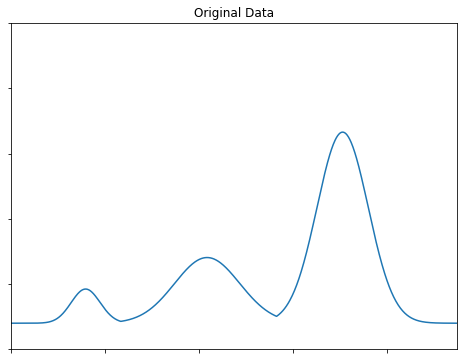

In [2]:
# Ορίζουμε τις παραμέτρους για τις τρεις Gaussians
mean_values = [0, 3, -2.5]  # Μέσες τιμές
variance_values = [0.5, 0.3, 0.1]  # Διακυμάνσεις

# Δημιουργούμε ένα εύρος τιμών από -10 έως 10 για τον άξονα x
x = np.linspace(-4, 5.5, 1000)

gaussians = []
for mean, variance in zip(mean_values, variance_values):
    gaussian = np.exp(-((x - mean)**2) / (2 * variance)) / np.sqrt(2 * np.pi * variance)
    gaussians.append(gaussian)

# Παίρνουμε τα ανώτερα σημεία από τις Gaussian καμπάνες
max_gaussian = np.maximum.reduce(gaussians)
for i in range(1000):
    max_gaussian[i] = max_gaussian[i]*i**1.5

max_gaussian = max_gaussian/1000-3    

# Plot the original and custom jittered Gaussian curves
plt.figure(figsize=(8, 6))

# Original Max Gaussian
plt.plot(x, max_gaussian, linewidth=1.5, alpha=1)
plt.title('Original Data')
plt.xlim(-4, 5.5)
plt.ylim(-5, 20)
plt.tick_params(labelbottom=False, labelleft=False)


# Show the plot
plt.show()

# Drawing No1

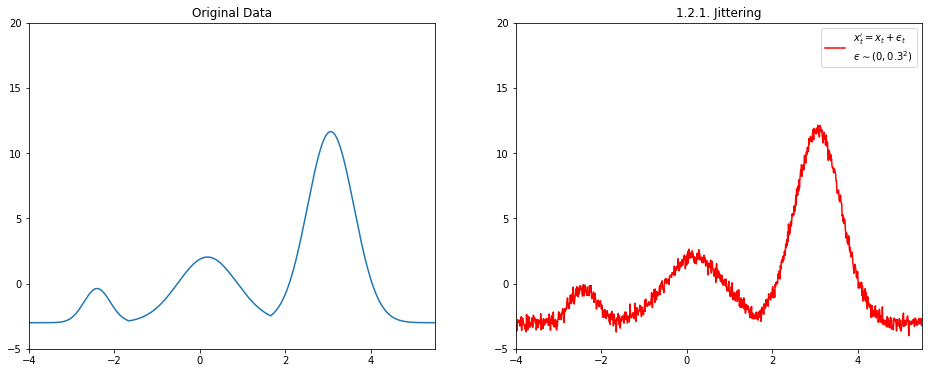

In [3]:
# JITTERING
std_dev = 0.3

# Generating Gaussian noise with mean 0 and standard deviation σ for each time step
epsilon = np.random.normal(0, std_dev, size=x.shape)
jittered_max_gaussian_custom = max_gaussian + epsilon

# Plot the original, jittered, and mirrored Gaussian curves
plt.figure(figsize=(16, 6))

# Original Max Gaussian
plt.subplot(1, 2, 1)
plt.plot(x, max_gaussian, linewidth=1.5, alpha=1)
plt.title('Original Data')
plt.xlim(-4, 5.5)
plt.ylim(-5, 20)


# Custom Jittered Max Gaussian
plt.subplot(1, 2, 2)
plt.plot(x, jittered_max_gaussian_custom, 'r', linewidth=1.5, label=fr'$x^\prime_{{t}} = x_{{t}} + ϵ_{{t}}$' + '\n' + fr'$ϵ \sim (0, {std_dev}^2)$')
plt.title('1.2.1. Jittering')
plt.xlim(-4, 5.5)
plt.ylim(-5, 20)
plt.legend()

# Drawing No2

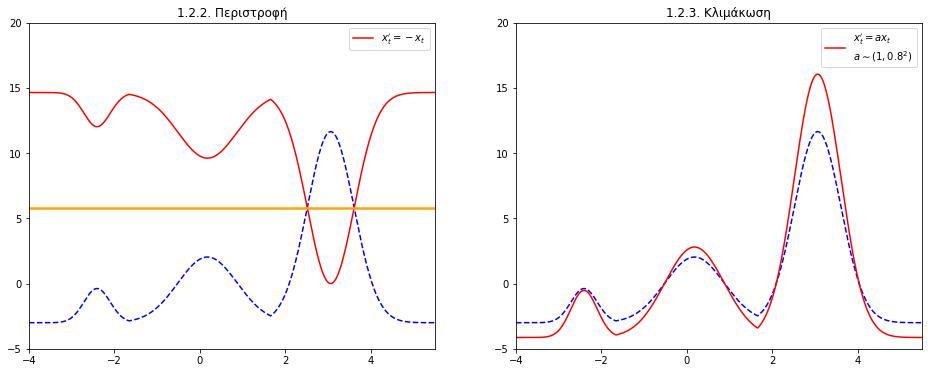

In [4]:
# MIRRORING
mirror_axis = np.max(max_gaussian) / 2

# Mirroring the data involves flipping the y values around the mirror axis
mirrored_y = 2 * mirror_axis - max_gaussian

# SCALING
std_dev_for_alpha = 0.8
np.random.seed(12)

# Generating α from a Gaussian distribution with mean 1 and standard deviation σ
alpha = np.random.normal(1, std_dev_for_alpha)
# Apply scaling to the original max Gaussian data
scaled_max_gaussian = alpha * max_gaussian


plt.figure(figsize=(16, 6))

# Mirrored Max Gaussian
plt.subplot(1, 2, 1)
plt.plot(x, max_gaussian, 'b--', linewidth=1.5)  # Original data in dashed blue line
plt.plot(x, mirrored_y, 'r', linewidth=1.5, label=fr'$x^\prime_{{t}} = - x_{{t}}$')
plt.axhline(y=np.max(max_gaussian) / 2, color='orange', linewidth=2.5)
plt.title('1.2.2. Περιστροφή')
plt.xlim(-4, 5.5)
plt.ylim(-5, 20)
plt.legend()

# Plot the scaled data
plt.subplot(1, 2, 2)
plt.plot(x, max_gaussian, 'b--', linewidth=1.5)
plt.plot(x, scaled_max_gaussian, 'r', linewidth=1.5, label=fr'$x^\prime_{{t}} = a x_{{t}}$' + '\n' + fr'$a \sim (1, {std_dev_for_alpha}^2)$')
plt.title('Jittered Data')
plt.title('1.2.3. Κλιμάκωση')
plt.xlim(-4, 5.5)
plt.ylim(-5, 20)
plt.legend()

# Show the plot
plt.show()

# Drawing No3

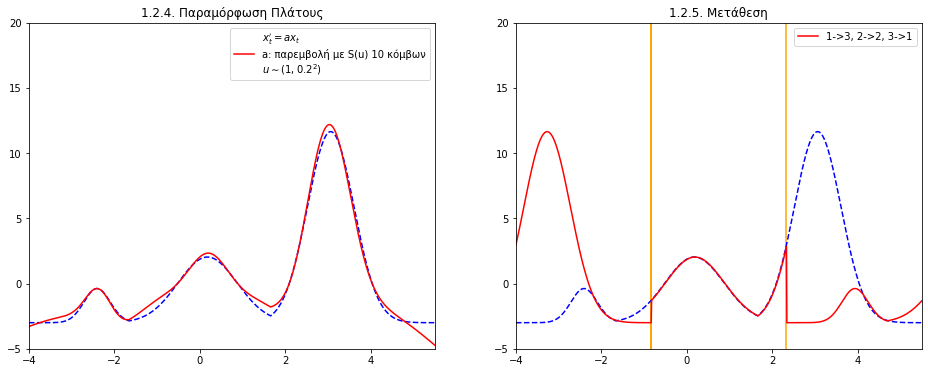

In [5]:
np.random.seed(12)

# PARAMORFOSI PLATOYS
num_knots = 10
std_dev_knots = 0.2

# Generate random knot values from a Gaussian distribution N(1, σ^2)
knot_values = np.random.normal(1, std_dev_knots, num_knots)
knot_locations = np.linspace(0, len(max_gaussian)-1, num_knots, dtype=int)
spline = CubicSpline(knot_locations, knot_values, bc_type='natural')

# Create αt for each time step by evaluating the spline across the time series
alpha_t = spline(np.arange(len(max_gaussian)))
# Apply magnitude warping to the original max Gaussian data
warped_max_gaussian = alpha_t * max_gaussian

# ANTIMETATHESI
# Κόβουμε τη χρονοσειρά σε τρία ίσα τμήματα κατά τον άξονα x
segment_1 = max_gaussian[:len(warped_max_gaussian)//3]
segment_2 = max_gaussian[len(warped_max_gaussian)//3:2*len(warped_max_gaussian)//3]
segment_3 = max_gaussian[2*len(warped_max_gaussian)//3:]

# Αναδιατάσσουμε τα τμήματα: το 1ο γίνεται 3ο, το 2ο παραμένει ίδιο, το 3ο γίνεται 1ο
rearranged_data = np.concatenate((segment_3, segment_2, segment_1))

# Plot the original and warped Gaussian curves
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(x, max_gaussian, 'b--', linewidth=1.5)
plt.plot(x, warped_max_gaussian, 'r', linewidth=1.5, label=fr'$x^\prime_{{t}} = a x_{{t}}$' + '\n' + fr'a: παρεμβολή με S(u) {num_knots} κόμβων'
         + '\n' + fr'$u \sim (1, {std_dev_knots}^2)$')
plt.title('1.2.4. Παραμόρφωση Πλάτους')
plt.xlim(-4, 5.5)
plt.ylim(-5, 20)
plt.legend()


plt.subplot(1, 2, 2)
plt.axvline(x=x[len(segment_1)], color='orange', linewidth=2)
plt.axvline(x=x[len(segment_1) + len(segment_2)], color='orange', linewidth=1.5)
plt.plot(x, max_gaussian, 'b--', linewidth=1.5)
plt.plot(x, rearranged_data, 'r', linewidth=1.5, label= "1->3, 2->2, 3->1")
plt.title('1.2.5. Μετάθεση')
plt.xlim(-4, 5.5)
plt.ylim(-5, 20)
plt.legend()

plt.show()

# Drawing No4

(-5.0, 20.0)

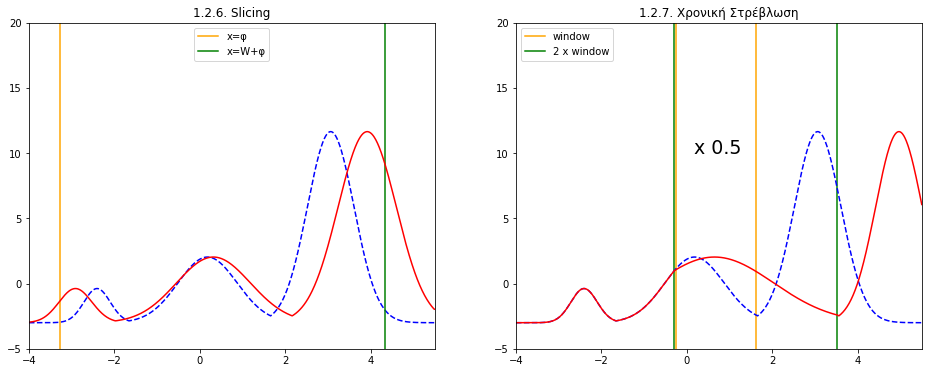

In [6]:
# PERIKOPH
W = 800 # Μέγεθος παραθύρου
np.random.seed(12)
φ =np.random.randint(1, len(max_gaussian) - W)  # Τυχαίος αριθμός για την αρχή του παραθύρου

# Κόβουμε τη χρονοσειρά
sliced_max_gaussian = max_gaussian[φ:φ + W]
sliced_max_gaussian_resampled = np.interp(np.linspace(0, W, 1000), np.arange(W), sliced_max_gaussian)

# Σχεδίαση της αρχικής και της τεμαχισμένης χρονοσειράς
plt.figure(figsize=(16, 6))

#TIME WINDOW
time_warping_function = max_gaussian.copy()
factor = 2
window = 200
start = np.random.randint(0, len(time_warping_function) - 2*window)  # Τυχαία επιλογή της αρχικής θέσης start

a = np.interp(np.linspace(0, window, factor * window), np.arange(window), time_warping_function[start:start + window])

# Ενημέρωση των υπολοίπων στοιχείων του series για να μετακινηθούν κατά 20 θέσεις προς τα δεξιά
time_warping_function[start:] = np.roll(time_warping_function[start :], window)
# Αντικατάσταση των τελευταίων 20 στοιχείων του series με τα δεδομένα από το 'a'
time_warping_function[start:start + factor * window] = a

# Perikoph
plt.subplot(1, 2, 1)
plt.plot(x, max_gaussian, 'b--', linewidth=1.5)
plt.axvline(x=x[φ], color='orange', linewidth=1.5, label= "x=φ")
plt.axvline(x=x[φ+W], color='g', linewidth=1.5, label= "x=W+φ")
plt.plot(x, sliced_max_gaussian_resampled, 'r', linewidth=1.5)
plt.title('1.2.6. Slicing')
plt.legend()
plt.xlim(-4, 5.5)
plt.ylim(-5, 20)

#time window
plt.subplot(1, 2, 2)
plt.axvline(x=x[start], color='green', linewidth=1.5)
plt.axvline(x=x[start]+0.05, color='orange', linewidth=1.5, label="window")
plt.axvline(x=x[start+ window], color='orange', linewidth=1.5)
plt.axvline(x=x[start+ 2*window], color='green', linewidth=1.5, label="2 x window")
plt.annotate('x 0.5', xy=(x[start + window], 10), xytext=(x[start] + 0.45, 10), fontsize=19, color='black', alpha=1)
plt.plot(x, max_gaussian, 'b--', linewidth=1.5)
plt.plot(x,time_warping_function, 'r', linewidth=1.5)
plt.title('1.2.7. Χρονική Στρέβλωση')
plt.legend()
plt.xlim(-4, 5.5)
plt.ylim(-5, 20)

# Drawing No5

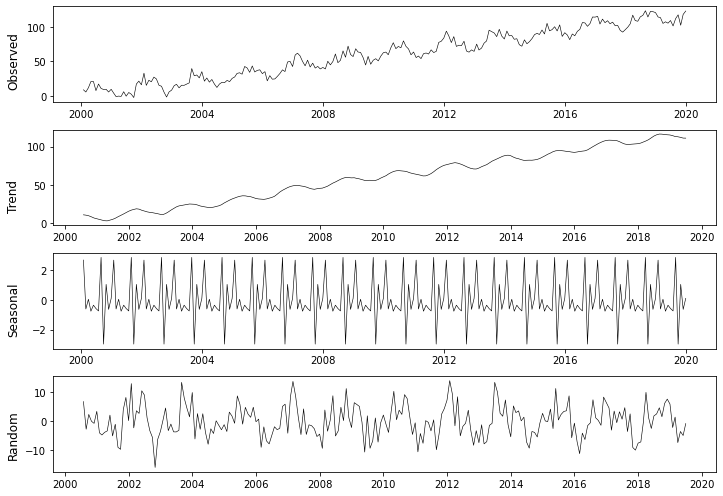

In [7]:
# Set the random seed for reproducibility
np.random.seed(0)

# Create a time series for a 20 year period with a clear trend and seasonality
time = pd.date_range(start='2000-01-01', periods=240, freq='M') # Monthly data over 20 years
trend = np.linspace(start=0, stop=120, num=240) # Linear trend
seasonal = 10 * np.sin(np.linspace(start=0, stop=24*np.pi, num=240)) # Seasonal component
random = np.random.normal(loc=0.0, scale=5.0, size=240) # Random noise

# Combine components to create the observed time series
observed = trend + seasonal + random

# Perform seasonal decomposition
result = seasonal_decompose(observed, model='additive', period=12)

# Plot the observed time series and its components
line_style = {'color': 'black', 'linewidth': 0.6}
plt.figure(figsize=(10, 7))

# Adjust subplot titles to be on the left and vertical
# Plot the observed data
plt.subplot(411)
plt.plot(time, result.observed, **line_style)
plt.title('Observed', rotation='vertical', x=-0.05, y=0.1, ha='right')

# Plot the trend component
plt.subplot(412)
plt.plot(time, result.trend, **line_style)
plt.title('Trend', rotation='vertical', x=-0.05, y=0.1, ha='right')

# Plot the seasonal component
plt.subplot(413)
plt.plot(time, result.seasonal,**line_style)
plt.title('Seasonal', rotation='vertical', x=-0.05, y=0.1, ha='right')

# Plot the residual component
plt.subplot(414)
plt.plot(time, result.resid, **line_style)
plt.title('Random', rotation='vertical', x=-0.05, y=0.1, ha='right')

# Enhancing the layout
plt.tight_layout()

# Show plot
plt.show()



# Drawing No6

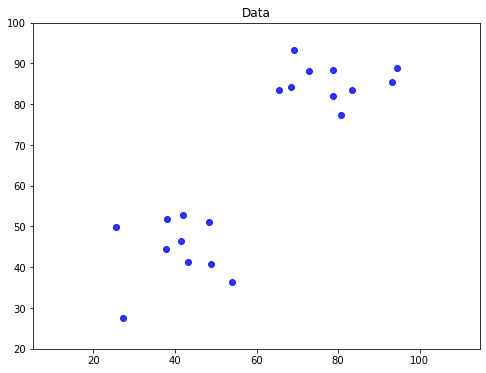

In [8]:
# Define the centers for the clusters
center1 = np.array([40, 40])
center2 = np.array([80, 80])

# Generate data around the specified centers within a maximum distance of 15
np.random.seed(0)
data1 = center1 + np.random.uniform(-15, 15, size=(10, 2))
data2 = center2 + np.random.uniform(-15, 15, size=(10, 2))
data = np.vstack((data1, data2))

# Compute the radius of each cluster as the farthest point from the center + 2
radius1 = np.max(np.sqrt(np.sum((data1 - center1) ** 2, axis=1))) + 2
radius2 = np.max(np.sqrt(np.sum((data2 - center2) ** 2, axis=1))) + 2

# Plotting the results with the adjusted data
plt.figure(figsize=(8, 6))

# Plot the data points
plt.scatter(data1[:, 0], data1[:, 1], c='blue', alpha=0.8)
plt.scatter(data2[:, 0], data2[:, 1], c='blue', alpha=0.8)

# Set equal scaling by changing the axis limits
plt.xlim(20, 100)
plt.ylim(20, 100)
plt.gca().set_aspect('equal', adjustable='datalim')

plt.title("Data")
plt.show()


# Drawing No7

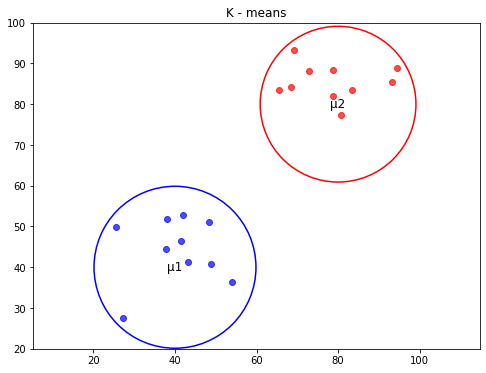

In [9]:
# Define the centers for the clusters
center1 = np.array([40, 40])
center2 = np.array([80, 80])

# Generate data around the specified centers within a maximum distance of 15
np.random.seed(0)
data1 = center1 + np.random.uniform(-15, 15, size=(10, 2))
data2 = center2 + np.random.uniform(-15, 15, size=(10, 2))
data = np.vstack((data1, data2))

# Compute the radius of each cluster as the farthest point from the center + 2
radius1 = np.max(np.sqrt(np.sum((data1 - center1) ** 2, axis=1))) + 2
radius2 = np.max(np.sqrt(np.sum((data2 - center2) ** 2, axis=1))) + 2

# Plotting the results with the adjusted data
plt.figure(figsize=(8, 6))

# Plot the data points
plt.scatter(data1[:, 0], data1[:, 1], c='blue', alpha=0.7)
plt.scatter(data2[:, 0], data2[:, 1], c='red', alpha=0.7)

# Draw circles around the clusters
circle1 = plt.Circle(center1, radius1, color='blue', fill=False, lw=1.5)
circle2 = plt.Circle(center2, radius2, color='red', fill=False, lw=1.5)
plt.gca().add_artist(circle1)
plt.gca().add_artist(circle2)

# Annotate the centroids
plt.text(center1[0], center1[1], 'μ1', color='black', fontsize=12, ha='center', va='center')
plt.text(center2[0], center2[1], 'μ2', color='black', fontsize=12, ha='center', va='center')

# Set equal scaling by changing the axis limits
plt.xlim(20, 100)
plt.ylim(20, 100)
plt.gca().set_aspect('equal', adjustable='datalim')

plt.title("K - means")
plt.show()


# Drawing No8

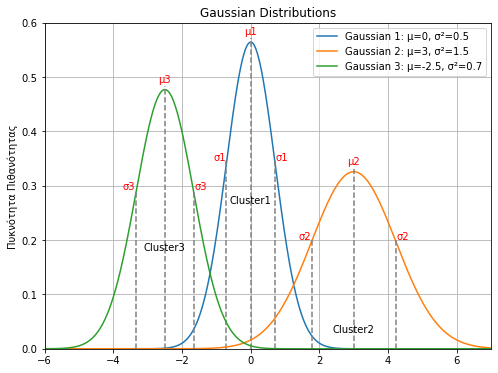

In [10]:
# Ορίζουμε τις παραμέτρους για τις τρεις Gaussians
mean_values = [0, 3, -2.5]  # Μέσες τιμές
variance_values = [0.5, 1.5, 0.7]  # Διακυμάνσεις

# Δημιουργούμε ένα εύρος τιμών από -5 έως 5 για τον άξονα x
x = np.linspace(-6, 7, 1000)

gaussians = []
for mean, variance in zip(mean_values, variance_values):
    gaussian = np.exp(-((x - mean)**2) / (2 * variance)) / np.sqrt(2 * np.pi * variance)
    gaussians.append(gaussian)

# Σχεδιάζουμε τις Gaussians με τις απαιτούμενες γραμμές
plt.figure(figsize=(8, 6))

for idx, (mean, variance, gaussian) in enumerate(zip(mean_values, variance_values, gaussians)):
    # Σχεδιάζουμε την καμπάνα Gaussian
    plt.plot(x, gaussian, label=f'Gaussian {idx + 1}: μ={mean}, σ²={variance}')
    
    # Σχεδιάζουμε την κάθετη γραμμή για τη μέση τιμή
    plt.axvline(x=mean, color='grey', linestyle='--', ymax=gaussian.max() / plt.ylim()[1])
    plt.text(mean, gaussian.max()+0.01, f'μ{idx+1}', ha='center', va='bottom', color='red')
    plt.text(mean, gaussian.max()-0.3, f'Cluster{idx+1}', ha='center', va='bottom')
    
    # Σχεδιάζουμε τις κάθετες γραμμές για την τυπική απόκλιση
    std_dev = np.sqrt(variance)
    y_max_std_neg = np.exp(-((mean - std_dev - mean)**2) / (2 * variance)) / np.sqrt(2 * np.pi * variance)
    y_max_std_pos = np.exp(-((mean + std_dev - mean)**2) / (2 * variance)) / np.sqrt(2 * np.pi * variance)
    plt.axvline(x=mean - std_dev, color='grey', linestyle='--', ymax=y_max_std_neg / plt.ylim()[1])
    plt.text(mean - std_dev-0.2, y_max_std_neg, f'σ{idx+1}', ha='center', va='bottom', color='red')
    plt.axvline(x=mean + std_dev, color='grey', linestyle='--', ymax=y_max_std_pos / plt.ylim()[1])
    plt.text(mean + std_dev+0.2, y_max_std_pos, f'σ{idx+1}', ha='center', va='bottom', color='red')
    
# Set equal scaling by changing the axis limits
plt.xlim(-6, 7)
plt.ylim(0, 0.6)
#plt.gca().set_aspect('equal', adjustable='datalim')

plt.title("K - means")
plt.title('Gaussian Distributions')
plt.ylabel('Πυκνότητα Πιθανότητας')
plt.legend()
plt.grid(True)
plt.show()


# Drawing No9

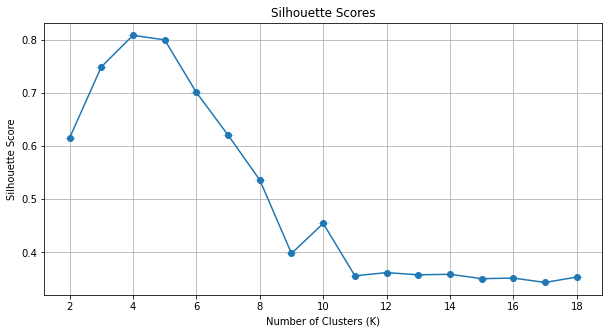

In [11]:
# Δημιουργία συνθετικών δεδομένων
X, _ = make_blobs(n_samples=500, centers=5, cluster_std=0.60, random_state=42)

# Υπολογισμός του silhouette score για διάφορες τιμές του K
k_values = range(2, 19)
silhouette_scores = []
silhouette_scores_std = [] # Αποθηκεύουμε επίσης τις τυπικές αποκλίσεις για το error bar

# Επειδή θέλουμε να υπολογίσουμε το σφάλμα, θα κάνουμε πολλαπλές επαναλήψεις για κάθε K
n_repeats = 10

for k in k_values:
    scores = []
    for _ in range(n_repeats):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        scores.append(silhouette_score(X, kmeans.labels_))
    silhouette_scores.append(np.mean(scores))
    silhouette_scores_std.append(np.std(scores))

# Σχεδιασμός του διαγράμματος με το επιθυμητό στυλ
plt.figure(figsize=(10, 5))
plt.errorbar(k_values, silhouette_scores, yerr=silhouette_scores_std, fmt='-o', ecolor='lightblue', capsize=5)
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Drawing No10

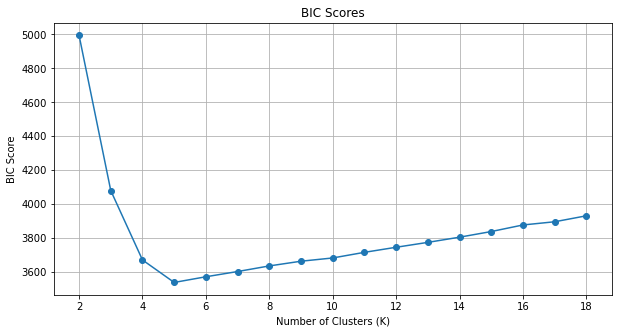

In [12]:
bic_scores = []

for k in k_values:
    gmm = GMM(n_components=k, random_state=42)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))

# Σχεδιασμός του διαγράμματος με το επιθυμητό στυλ
plt.figure(figsize=(10, 5))
plt.plot(k_values, bic_scores, marker='o', linestyle='-')
plt.title("BIC Scores")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("BIC Score")
plt.grid(True)
plt.show()



# Drawing No11

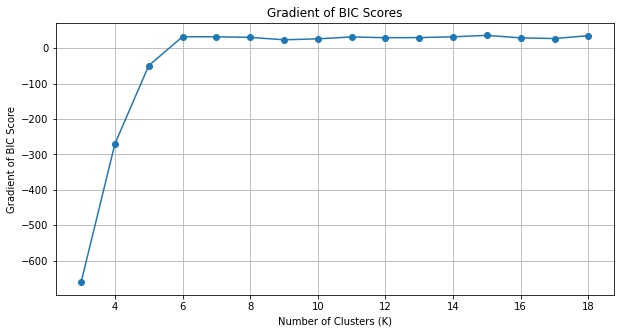

In [13]:
# Υπολογισμός του gradient του BIC score
bic_gradient = np.gradient(bic_scores, k_values)[1:]

# Σχεδιασμός του γραφήματος του gradient
plt.figure(figsize=(10, 5))
plt.plot(k_values[1:], bic_gradient, marker='o', linestyle='-')
plt.title("Gradient of BIC Scores")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Gradient of BIC Score")
plt.grid(True)
plt.show()

# Drawing No12

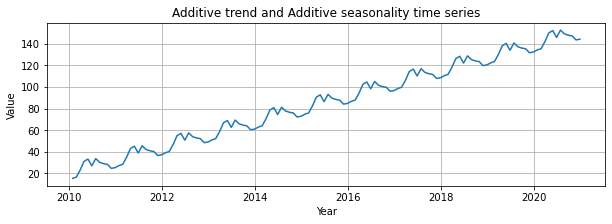

In [14]:
# Based on the provided code, let's add a small pattern of noise to each season.
np.random.seed(0)  # Seed the random number generator for reproducibility

# Recreate the trend and seasonality from the provided code
date_range = pd.date_range(start='2010', end='2021', freq='M')
trend = np.linspace(start=10, stop=140, num=len(date_range))
seasonal_period = 12
seasonal_amplitude = 15
seasonality = np.tile(np.sin(np.linspace(0, 1 * np.pi, seasonal_period)), int(len(date_range)/seasonal_period))

# Generate a small pattern of noise and repeat it for each season
noise_pattern = np.random.normal(loc=0, scale=3, size=seasonal_period)
noise = np.tile(noise_pattern, int(len(date_range)/seasonal_period))

# Combine the trend, seasonality, and noise to create the time series
time_series_with_noise = trend + seasonal_amplitude * seasonality + noise

# Plot the time series with noise
plt.figure(figsize=(10, 3))
plt.plot(date_range, time_series_with_noise)
plt.title('Additive trend and Additive seasonality time series')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True)
plt.show()


# Drawing No13

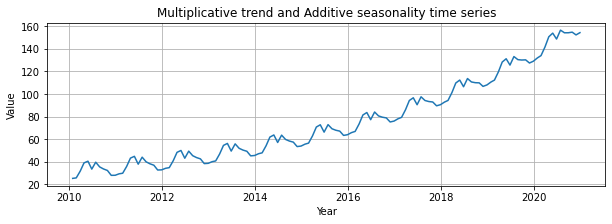

In [15]:
# Create a multiplicative trend. Instead of a linear trend, we'll use an exponential growth to simulate a multiplicative trend.
multiplicative_trend = np.exp(np.linspace(start=np.log(20), stop=np.log(150), num=len(date_range)))

# Combine the multiplicative trend, additive seasonality, and noise to create the time series
time_series_multiplicative_trend = multiplicative_trend + seasonal_amplitude * seasonality + noise

# Plot the time series with multiplicative trend and additive seasonality with noise pattern
plt.figure(figsize=(10, 3))
plt.plot(date_range, time_series_multiplicative_trend)
plt.title('Multiplicative trend and Additive seasonality time series')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True)
plt.show()


# Drawing No14

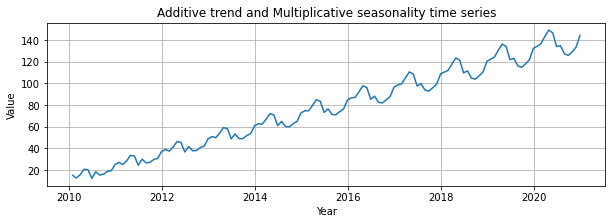

In [16]:

# Recreate the additive trend from the provided code
trend = np.linspace(start=10, stop=140, num=len(date_range))
seasonal_amplitude = 0.08  # This will be a 10% effect relative to the trend.
seasonality = (1 + seasonal_amplitude * np.sin(np.linspace(0, 2 * np.pi, seasonal_period)))

# Repeat the multiplicative seasonal component for the whole date range
seasonality = np.tile(seasonality, int(len(date_range)/seasonal_period))

# Combine the trend and the multiplicative seasonality.
# Since we are dealing with multiplicative seasonality, we multiply the trend with the seasonal component.
time_series_additive_trend_multiplicative_seasonality = trend * seasonality

# Add the noise pattern that was previously generated
time_series_additive_trend_multiplicative_seasonality += noise

# Plot the time series with additive trend and multiplicative seasonality
plt.figure(figsize=(10, 3))
plt.plot(date_range, time_series_additive_trend_multiplicative_seasonality)
plt.title('Additive trend and Multiplicative seasonality time series')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Drawing No15

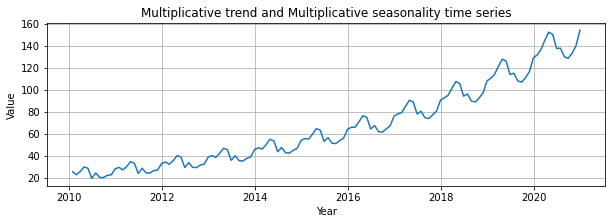

In [17]:
# Now, let's create a time series with both a multiplicative trend and multiplicative seasonality.

# Recreate the multiplicative trend from the provided code
multiplicative_trend = np.exp(np.linspace(start=np.log(20), stop=np.log(150), num=len(date_range)))

# Create a multiplicative seasonality component.
# Similar to before, but now the seasonal effect will be multiplicative in relation to the multiplicative trend.
seasonal_amplitude = 0.1  # A 10% effect relative to the trend
seasonality = (1 + seasonal_amplitude * np.sin(np.linspace(0, 2 * np.pi, seasonal_period)))

# Repeat the multiplicative seasonal component for the whole date range
seasonality = np.tile(seasonality, int(len(date_range)/seasonal_period))

# Combine the multiplicative trend and multiplicative seasonality
time_series_multiplicative_trend_seasonality = multiplicative_trend * seasonality

# Add the noise pattern
time_series_multiplicative_trend_seasonality += noise

# Plot the time series with multiplicative trend and multiplicative seasonality
plt.figure(figsize=(10, 3))
plt.plot(date_range, time_series_multiplicative_trend_seasonality)
plt.title('Multiplicative trend and Multiplicative seasonality time series')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True)
plt.show()


# Drawing No16

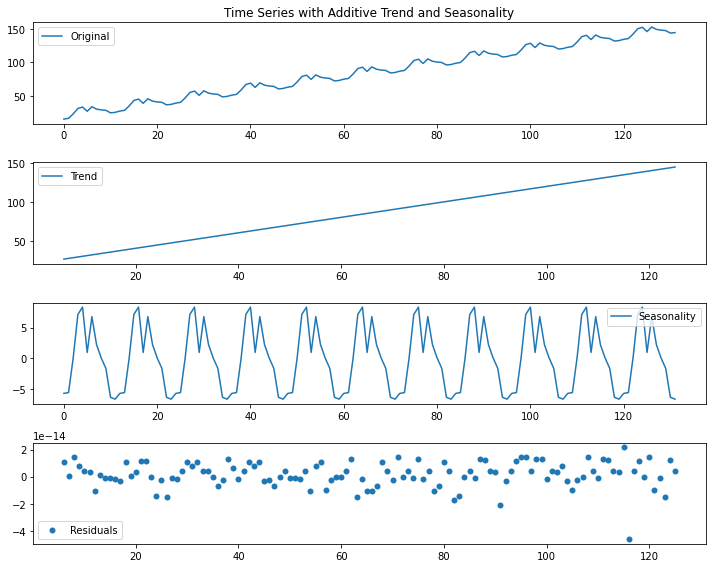

In [18]:
# Decompose the time series using an additive model
decomposition = seasonal_decompose(time_series_with_noise, model='additive', period=seasonal_period)

# Extract the trend, seasonality, and residual components
trend_component = decomposition.trend
seasonal_component = decomposition.seasonal
residual_component = decomposition.resid


# Plotting the original time series and its decomposed components with scatter plot for residuals
plt.figure(figsize=(10, 8))

# Original Time Series
plt.subplot(411)
plt.plot(time_series_with_noise, label='Original')
plt.legend(loc='best')
plt.title('Time Series with Additive Trend and Seasonality')

# Trend Component
plt.subplot(412)
plt.plot(trend_component, label='Trend')
plt.legend(loc='best')

# Seasonal Component
plt.subplot(413)
plt.plot(seasonal_component, label='Seasonality')
plt.legend(loc='best')

# Residual Component with scatter plot
plt.subplot(414)
plt.scatter(x=np.arange(len(residual_component)), y=residual_component, label='Residuals', lw=0.001)
plt.legend(loc='best')
plt.tight_layout()

plt.show()


# Drawing No17

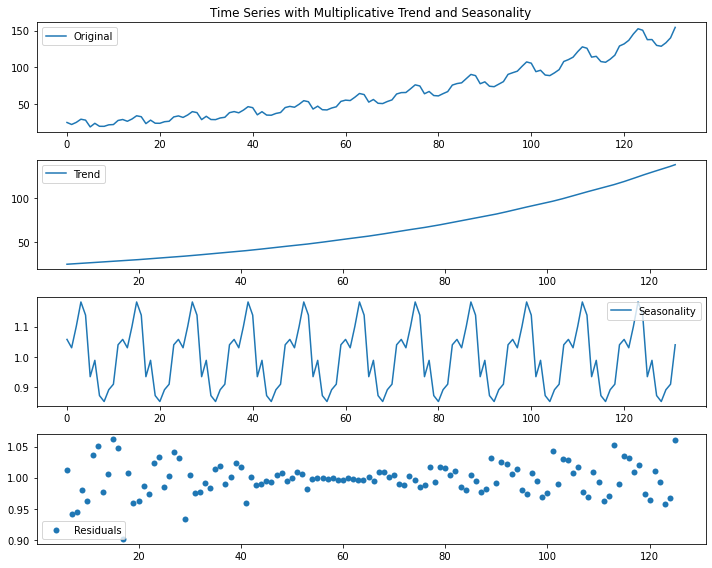

In [19]:
# Decompose the time series using a multiplicative model
decomposition_multiplicative = seasonal_decompose(time_series_multiplicative_trend_seasonality, model='multiplicative', period=seasonal_period)

# Extract the trend, seasonality, and residual components
trend_component_multiplicative = decomposition_multiplicative.trend
seasonal_component_multiplicative = decomposition_multiplicative.seasonal
residual_component_multiplicative = decomposition_multiplicative.resid

# Plotting the original time series and its decomposed components
plt.figure(figsize=(10, 8))

# Original Time Series
plt.subplot(411)
plt.plot(time_series_multiplicative_trend_seasonality, label='Original')
plt.legend(loc='best')
plt.title('Time Series with Multiplicative Trend and Seasonality')

# Trend Component
plt.subplot(412)
plt.plot(trend_component_multiplicative, label='Trend')
plt.legend(loc='best')

# Seasonal Component
plt.subplot(413)
plt.plot(seasonal_component_multiplicative, label='Seasonality')
plt.legend(loc='best')

# Residual Component with scatter plot
plt.subplot(414)
plt.scatter(x=np.arange(len(residual_component_multiplicative)), y=residual_component_multiplicative, label='Residuals', lw=0.001)
plt.legend(loc='best')
plt.tight_layout()

plt.show()


# Drawing No18

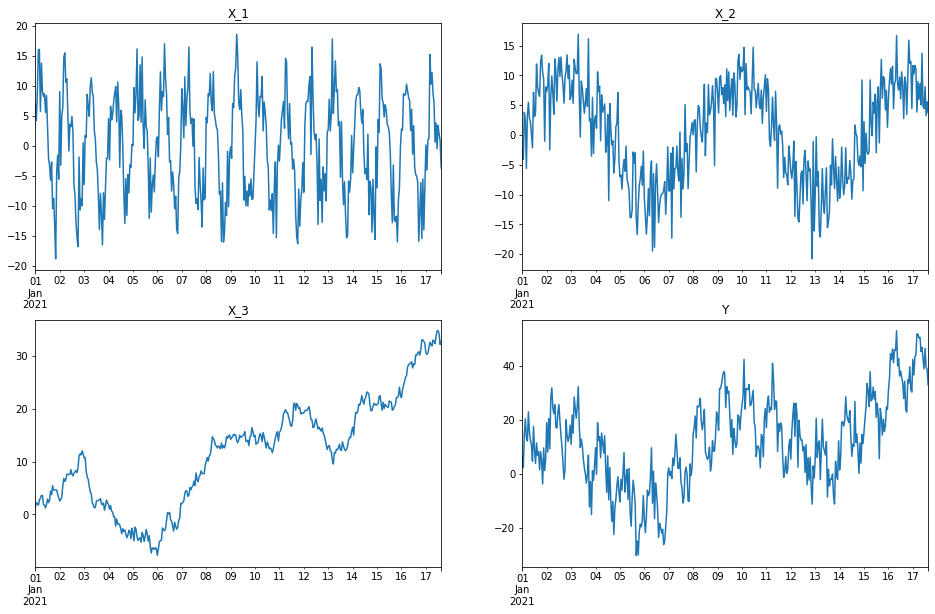

In [20]:
### CREATE SYNTHETIC DATA ###

np.random.seed(0)
n_series, timesteps = 1, 400

data1 = sim_seasonal_data(n_series=n_series, timesteps=timesteps, 
                          level=0, amp=10, freq=24, measure_noise=4)

data2 = sim_seasonal_data(n_series=n_series, timesteps=timesteps, 
                          level=0, amp=10, freq=24*7, measure_noise=4)

data3 = sim_randomwalk(n_series=n_series, timesteps=timesteps, 
                       process_noise=1, measure_noise=0)


data = data1[0] + data2[0] + data3[0]

df = pd.DataFrame({
    'X_1':data1[0],
    'X_2':data2[0],
    'X_3':data3[0],
    'Y':data
})

df.index = pd.date_range('2021', periods=len(df), freq='H')
cols = df.columns

### PLOT SYNTHETIC DATA ###

plt.figure(figsize=(16,10))

for i,c in enumerate(cols):
    
    plt.subplot(2,2,i+1)
    df[c].plot(ax=plt.gca(), title=c); plt.xlabel(None)

# Drawing No19

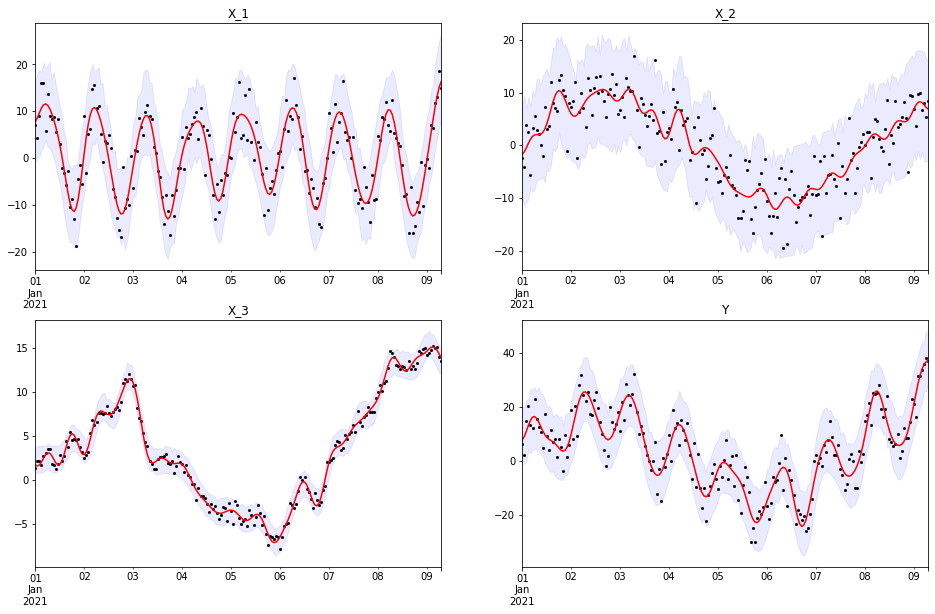

In [21]:
### TRAIN TEST SPLIT ###
window_shape = 24
time_h = 6
train = df.head(200)
test = df[~df.index.isin(train.index)]

### SMOOTH TRAIN DATA ###
smoother = SpectralSmoother(smooth_fraction=0.2, pad_len=12)
smoother.smooth(train.T)
bts_samples ={}

### BOOTSTRAP TRAIN DATA (ONLY FOR PLOTTING) ###
plt.figure(figsize=(16,10))
for i,c in enumerate(cols):
    
    plt.subplot(2,2,i+1)
    np.random.seed(i)
    bts = BootstrappingWrapper(SpectralSmoother(smooth_fraction=0.18, pad_len=12), 
                           bootstrap_type='mbb', block_length=24)
    bts_samples[c] = bts.sample(train[c], n_samples=100)
    
    pd.Series(smoother.smooth_data[i], index=train.index).plot(c='red')
    plt.scatter(train.index, smoother.data[i], c='black', s=4)
    plt.fill_between(train.index, bts_samples[c].min(0), bts_samples[c].max(0), alpha=0.08, color='blue')
    plt.title(c)

# Drawing No20

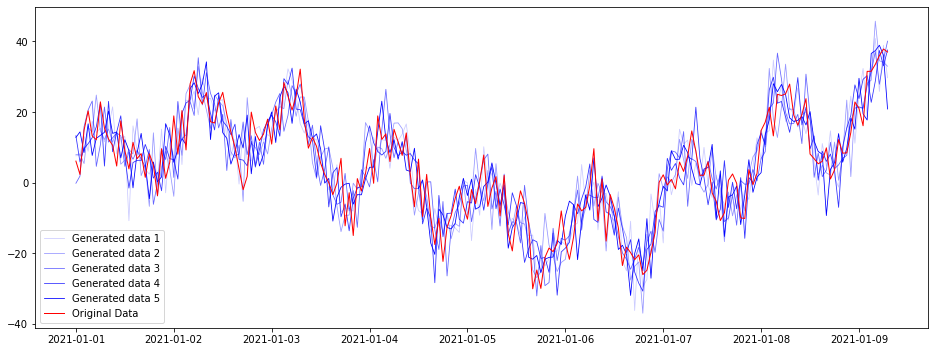

In [22]:
data = {}
cols2 = ['X_1', 'X_2', 'X_3']
plt.figure(figsize=(16,13))
ax1 = plt.subplot(2, 1, 1)

for j in range(1, 6):
    data[j] = 0
    for i, c in enumerate(cols2):
        data[j] = data[j] + bts_samples[c][j]

    ax1.plot(train.index, data[j], c='blue', label=f"Generated data {j}", alpha=j/5, lw=0.8)

ax1.plot(train.index, train['Y'], c='r', label="Original Data", alpha=1, lw=1)
ax1.legend(loc='best')

# Drawing No21

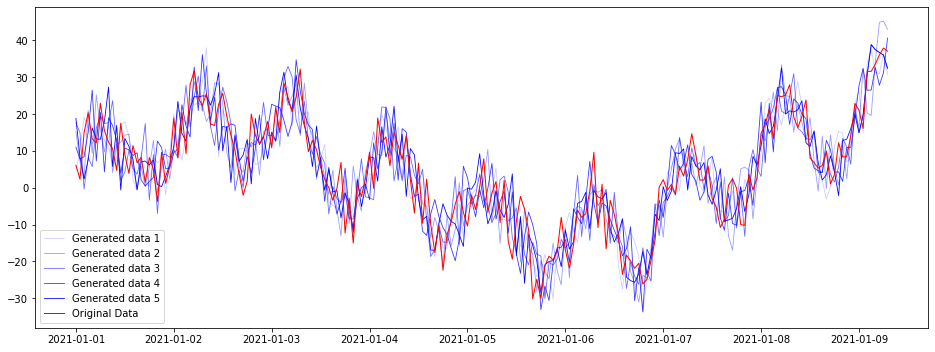

In [23]:
plt.figure(figsize=(16,13))
data = {}
ax1 = plt.subplot(2, 1, 1)

for j in range(1, 6):
    ax1.plot(train.index, bts_samples['Y'][j], c='blue', label=f"Generated data {j}", alpha=j/5, lw=0.8)

ax1.plot(train.index, train['Y'], c='r', label="Original Data", alpha=1, lw=1)
ax1.legend(loc='best')